# 把split作为标准,评价gim的精度

In [1]:
!pwd

/panda/eedy/ion_los-angle/s1_a064/notebook


In [2]:
from datetime import datetime
from mintpy.utils import ptime, readfile, writefile
import h5py
import numpy as np
from matplotlib import pyplot as plt, colorbar, ticker, colors
from mintpy.utils import ptime, readfile, writefile
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from mintpy.objects import timeseries
import math

In [3]:
# 定义文件路径
path_split = '../mintpy_split_ion_upsample/ion.h5'
path_GIM = '../mintpy_gim_ion_upsample/ion.h5'
path_hight_GIM = '../mintpy_hight_gim_ion_upsample/ion.h5'
path_cas = '../mintpy_cas_ion_upsample/ion.h5'
path_MIT = '../mintpy_MIT_gim_ion_upsample/ion.h5'

## 1.设为同一参考点和参考时间

In [4]:
# 构建文件路径列表
file_paths = [path_split, path_GIM, path_hight_GIM, path_MIT, path_cas]

# 遍历文件路径列表，依次执行 reference_point.py 和 reference_date.py 命令
for file_path in file_paths:
    # 构建 reference_point.py 命令
    ref_point_command = ['reference_point.py', file_path, '-y', '350', '-x', '100']
    try:
        # 执行 reference_point.py 命令
        subprocess.run(ref_point_command, check=True)
        print(f"针对 {file_path} 执行 reference_point.py 命令成功")
    except subprocess.CalledProcessError as e:
        print(f"针对 {file_path} 执行 reference_point.py 命令失败: {e}")

    # 构建 reference_date.py 命令
    ref_date_command = ['reference_date.py', file_path, '--ref-date', '20190123']
    try:
        # 执行 reference_date.py 命令
        subprocess.run(ref_date_command, check=True)
        print(f"针对 {file_path} 执行 reference_date.py 命令成功")
    except subprocess.CalledProcessError as e:
        print(f"针对 {file_path} 执行 reference_date.py 命令失败: {e}")

--------------------------------------------------
input reference point in y/x: (350, 100)
--------------------------------------------------
SAME reference pixel is already selected/saved in file, skip updating.
针对 ../mintpy_split_ion_upsample/ion.h5 执行 reference_point.py 命令成功
input reference date: 20190123
--------------------------------------------------
change reference date for file: /panda/eedy/ion_los-angle/s1_a064/mintpy_split_ion_upsample/ion.h5
input refDate is the same as the existing REF_DATE.
Nothing to be done.
time used: 00 mins 1.0 secs.
针对 ../mintpy_split_ion_upsample/ion.h5 执行 reference_date.py 命令成功
--------------------------------------------------
input reference point in y/x: (350, 100)
--------------------------------------------------
SAME reference pixel is already selected/saved in file, skip updating.
针对 ../mintpy_gim_ion_upsample/ion.h5 执行 reference_point.py 命令成功
input reference date: 20190123
--------------------------------------------------
change refere

## 2.读取ion的时间序列，用左上角右下角的值，获取距离和方位向坡度的时间序列

In [5]:
# 构建文件路径列表
file_paths = [path_split, path_GIM, path_hight_GIM, path_MIT, path_cas]
# 初始化存储 timeseries和dates 数据的列表
timeseries_list = []
timeseries_list = []
dates_list = []

# 循环读取每个文件的 timeseries 数据并进行处理
for path in file_paths:
    # 读取 timeseries 数据
    time_series = readfile.read(path, datasetName='timeseries')[0]
    time_series = np.squeeze(time_series)
    timeseries_list.append(time_series)

    # 读取日期数据
    obj = timeseries(path)
    obj.open()
    dates = ptime.date_list2vector(obj.dateList)[0]
    dates_list.append(dates)

# 将处理后的数据分别赋值给对应的变量
timeseries_split, timeseries_GIM, timeseries_hight_GIM, timeseries_MIT,timeseries_cas  = timeseries_list
dates_split, dates_GIM, dates_hight_GIM ,dates_MIT,dates_cas = dates_list

time_series,art = readfile.read(path_split, datasetName='timeseries')
a_piexl = float(art['AZIMUTH_PIXEL_SIZE'])
r_piexl = float(art['RANGE_PIXEL_SIZE'])

open timeseries file: ion.h5
open timeseries file: ion.h5
open timeseries file: ion.h5
open timeseries file: ion.h5
open timeseries file: ion.h5


# 3.计算vtec强度

In [6]:
from mintpy.simulation import iono
from mintpy import iono_tec
from mintpy.objects import ionex
from mintpy.objects import timeseries
from mintpy.utils import readfile

# 定义数据路径
tec_dir = '/home/eedy/data/aux/IONEX'
geom_file = '../mintpy_no_ion_upsample/geo/geo_geometryRadar.h5'
ts_file = '../mintpy_no_ion_upsample/timeseries_SET_ERA5_demErr.h5'

# 获取日期列表
date_list = timeseries(ts_file).get_date_list()

# 读取元数据
meta = readfile.read_attribute(ts_file)
utc_sec = float(meta['CENTER_LINE_UTC'])

# 下载 IONEX 文件
tec_files = iono_tec.download_ionex_files(date_list, tec_dir, sol_code='jpl')

# 准备电离层几何信息
iono_inc_angle, iono_lat, iono_lon, iono_height = iono.prep_geometry_iono(geom_file, box=None, iono_height=450e3, print_msg=True)

# 初始化 vtec 列表
vtec = []

# 遍历每个 IONEX 文件
for tec_file in tec_files:
    # 获取电离层总电子含量 (VTEC) 值
    print(tec_file)
    if tec_file == '/home/eedy/data/aux/IONEX/jplg0850.22i':
        vtec_value = np.nan
    else:
        vtec_value = ionex.get_ionex_value(tec_file, utc_sec, lat=36.0835, lon=-117.9903, interp_method='linear3d', rotate_tec_map=True, print_msg=True)
    # 将 VTEC 值添加到列表中
    vtec.append(vtec_value)


------------------------------------------------------------------------------
downloading GNSS-based TEC products in IONEX format from NASA/CDDIS ...
https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/atmospheric_products.html
number of TEC files to download: 293
local TEC file directory: /home/eedy/data/aux/IONEX
--------------------
DATE 1/1: 20220326
wget --continue --auth-no-challenge "https://cddis.nasa.gov/archive/gnss/products/ionex/2022/085/jplg0850.22i.Z"


--2025-04-22 14:57:10--  https://cddis.nasa.gov/archive/gnss/products/ionex/2022/085/jplg0850.22i.Z
正在解析主机 cddis.nasa.gov (cddis.nasa.gov)... 198.118.199.52, 2001:4d0:241a:442::52
正在连接 cddis.nasa.gov (cddis.nasa.gov)|198.118.199.52|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://urs.earthdata.nasa.gov/oauth/authorize?client_id=gDQnv1IO0j9O2xXdwS8KMQ&response_type=code&redirect_uri=https%3A%2F%2Fcddis.nasa.gov%2Fproxyauth&state=aHR0cDovL2NkZGlzLm5hc2EuZ292L2FyY2hpdmUvZ25zcy9wcm9kdWN0cy9pb25leC8yMDIyLzA4NS9qcGxnMDg1MC4yMmkuWg [跟随至新的 URL]
--2025-04-22 14:57:12--  https://urs.earthdata.nasa.gov/oauth/authorize?client_id=gDQnv1IO0j9O2xXdwS8KMQ&response_type=code&redirect_uri=https%3A%2F%2Fcddis.nasa.gov%2Fproxyauth&state=aHR0cDovL2NkZGlzLm5hc2EuZ292L2FyY2hpdmUvZ25zcy9wcm9kdWN0cy9pb25leC8yMDIyLzA4NS9qcGxnMDg1MC4yMmkuWg
正在解析主机 urs.earthdata.nasa.gov (urs.earthdata.nasa.gov)... 198.118.243.33, 2001:4d0:241a:4081::89
正在连接 urs.earthdata.nasa.gov (urs.earthdata.nasa.gov)|198.118.243.33|:4

gzip --force --keep --decompress /home/eedy/data/aux/IONEX/jplg0850.22i.Z
[001/293] /home/eedy/data/aux/IONEX/jplg0860.15i: 839.85 KB
[002/293] /home/eedy/data/aux/IONEX/jplg1220.15i: 840.01 KB
[003/293] /home/eedy/data/aux/IONEX/jplg1700.15i: 839.93 KB
[004/293] /home/eedy/data/aux/IONEX/jplg1940.15i: 839.93 KB
[005/293] /home/eedy/data/aux/IONEX/jplg2180.15i: 839.93 KB
[006/293] /home/eedy/data/aux/IONEX/jplg2900.15i: 840.01 KB
[007/293] /home/eedy/data/aux/IONEX/jplg0450.16i: 839.93 KB
[008/293] /home/eedy/data/aux/IONEX/jplg0690.16i: 839.93 KB
[009/293] /home/eedy/data/aux/IONEX/jplg1170.16i: 839.93 KB
[010/293] /home/eedy/data/aux/IONEX/jplg1410.16i: 839.85 KB
[011/293] /home/eedy/data/aux/IONEX/jplg1650.16i: 840.01 KB
[012/293] /home/eedy/data/aux/IONEX/jplg1890.16i: 839.85 KB
[013/293] /home/eedy/data/aux/IONEX/jplg2130.16i: 839.93 KB
[014/293] /home/eedy/data/aux/IONEX/jplg3510.16i: 839.37 KB
[015/293] /home/eedy/data/aux/IONEX/jplg0090.17i: 839.37 KB
[016/293] /home/eedy/data/

In [7]:
dates_split = np.array(dates_split)
dates_GIM = np.array(dates_GIM)
dates_hight_GIM = np.array(dates_hight_GIM)
dates_MIT = np.array(dates_cas)
dates_cas = np.array(dates_cas)

timeseries_MIT = timeseries_MIT[:len(timeseries_MIT)-2]

# 找出五个日期数组的交集
common_dates = np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(dates_split, dates_GIM), dates_hight_GIM), dates_MIT), dates_cas)

# 确定每个日期数组中重叠日期对应的索引
indices_split = np.isin(dates_split, common_dates)
indices_GIM = np.isin(dates_GIM, common_dates)
indices_hight_GIM = np.isin(dates_hight_GIM, common_dates)
indices_MIT = np.isin(dates_MIT, common_dates)
indices_cas = np.isin(dates_cas, common_dates)

# 根据索引提取重叠时间部分的数据
timeseries_split = timeseries_split[indices_split]
timeseries_GIM = timeseries_GIM[indices_GIM]
timeseries_hight_GIM = timeseries_hight_GIM[indices_hight_GIM]
timeseries_MIT = timeseries_MIT[indices_MIT]
timeseries_cas = timeseries_cas[indices_cas]

vtec = np.array(vtec)
vtec = vtec[indices_GIM]

# 同时更新日期数组为重叠的日期
dates_split = dates_split[indices_split]
dates_GIM = dates_GIM[indices_GIM]
dates_hight_GIM = dates_hight_GIM[indices_hight_GIM]
dates_MIT = dates_MIT[indices_MIT]
dates_cas = dates_cas[indices_cas]

In [8]:
dates = dates_split

/tmp/ipykernel_2573181/3466418587.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


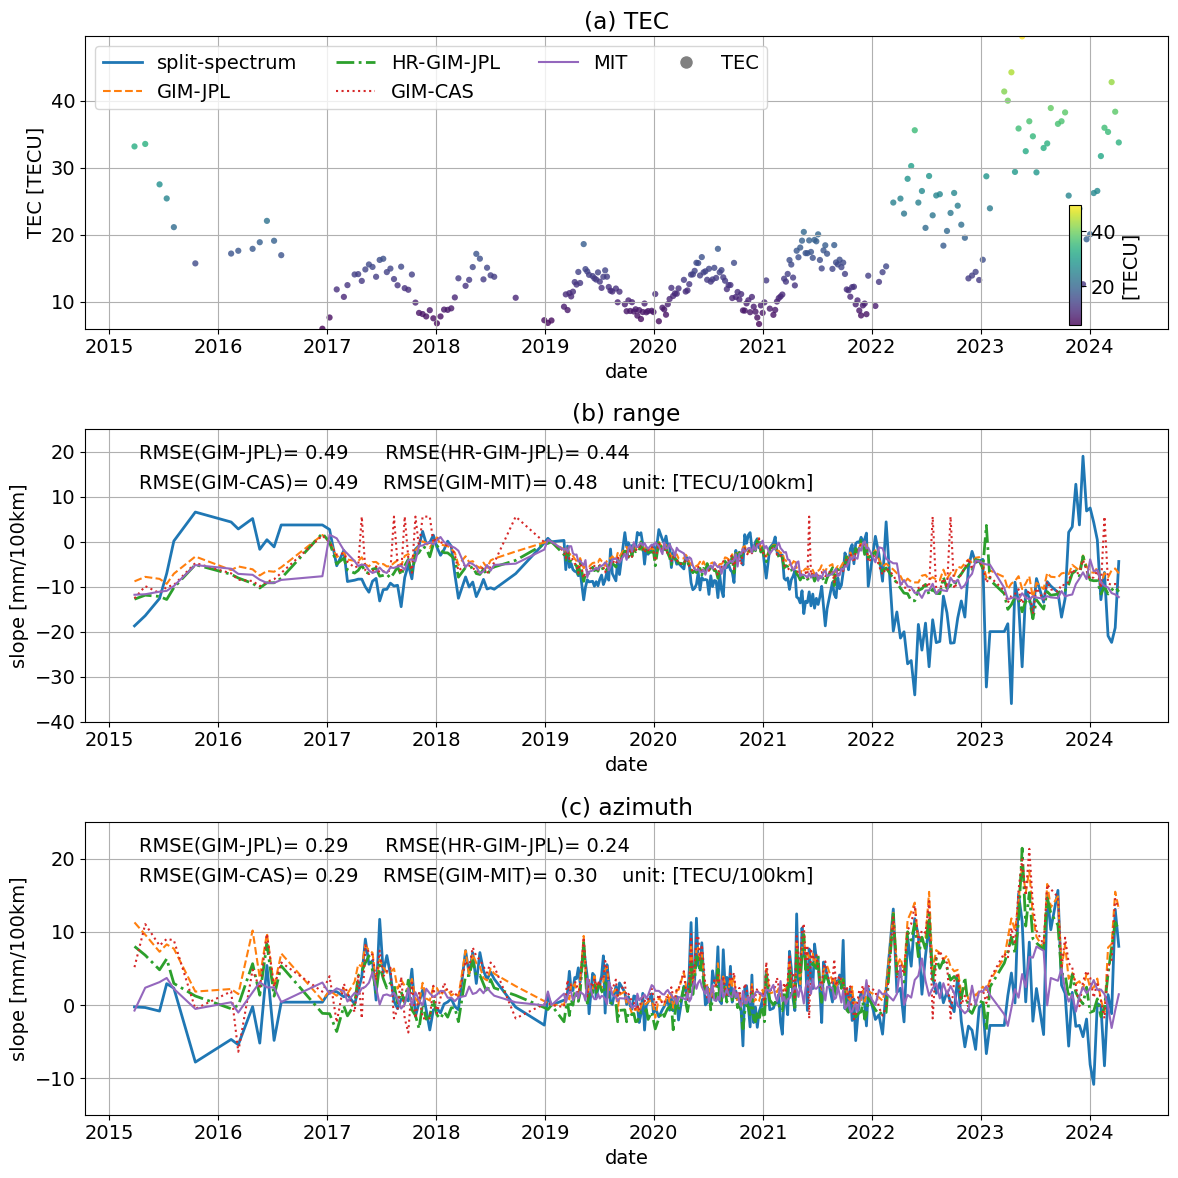

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.lines import Line2D

# 设置全局字体大小
plt.rcParams.update({'font.size': 14})


def calculate_diff_and_plot(ax, x1, y1, x2, y2, title, ylim, text_position='upper right'):
    # 计算两点间的实际物理距离
    distance = math.sqrt((abs(x1 - x2) * r_piexl) ** 2 + (abs(y1 - y2) * a_piexl) ** 2)
    # 计算每个数据集在两个点的差值的时间序列
    diff_split = timeseries_split[:, y1, x1] - timeseries_split[:, y2, x2]
    diff_split = diff_split / distance * 1e8
    diff_GIM = timeseries_GIM[:, y1, x1] - timeseries_GIM[:, y2, x2]
    diff_GIM = diff_GIM / distance * 1e8
    diff_hight_GIM = timeseries_hight_GIM[:, y1, x1] - timeseries_hight_GIM[:, y2, x2]
    diff_hight_GIM = diff_hight_GIM / distance * 1e8
    diff_MIT = timeseries_MIT[:, y1, x1] - timeseries_MIT[:, y2, x2]
    diff_MIT = diff_MIT / distance * 1e8
    diff_cas = timeseries_cas[:, y1, x1] - timeseries_cas[:, y2, x2]
    diff_cas = diff_cas / distance * 1e8

    # 定义颜色和线条样式
    linestyles = ['-', '--', '-.', ':', '-']

    # 在子图中绘制时间序列
    line1, = ax.plot(dates, diff_split, label='split-spectrum', linestyle=linestyles[0], linewidth=2)
    line2, = ax.plot(dates, diff_GIM, label='GIM-JPL', linestyle=linestyles[1])
    line3, = ax.plot(dates, diff_hight_GIM, label='HR-GIM-JPL', linestyle=linestyles[2], linewidth=2)
    line4, = ax.plot(dates, diff_cas, label='GIM-CAS', linestyle=linestyles[3])
    line5, = ax.plot(dates, diff_MIT, label='MIT', linestyle=linestyles[4])

    ax.set_title(title)
    ax.set_xlabel('date')
    ax.set_ylabel('slope [mm/100km]')
    ax.grid(True)

    # 计算RMSE
    rmse_GIM = np.sqrt(mean_squared_error(diff_split, diff_GIM))*((5.405e9)**2/40.31e16)/1000
    rmse_hight_GIM = np.sqrt(mean_squared_error(diff_split, diff_hight_GIM))*((5.405e9)**2/40.31e16)/1000
    rmse_cas = np.sqrt(mean_squared_error(diff_split, diff_cas))*((5.405e9)**2/40.31e16)/1000
    rmse_MIT = np.sqrt(mean_squared_error(diff_split, diff_MIT))*((5.405e9)**2/40.31e16)/1000

    # 在指定位置添加RMSE和R2文本
    textstr_GIM = (f'RMSE(GIM-JPL)= {rmse_GIM:.2f}')
    textstr_hight_GIM = (f'RMSE(HR-GIM-JPL)= {rmse_hight_GIM:.2f}')
    textstr_MIT = (f'RMSE(GIM-MIT)= {rmse_MIT:.2f}')
    textstr_cas = (f'RMSE(GIM-CAS)= {rmse_cas:.2f}')
    # 合并文本并按两行显示
    text1 = textstr_GIM + '      ' + textstr_hight_GIM
    text2 = textstr_cas + '    ' + textstr_MIT + '    ' + f'unit: [TECU/100km]'

    # 放置文本在左上方
    ax.text(0.05, 0.95, text1, transform=ax.transAxes, va='top', ha='left')
    ax.text(0.05, 0.85, text2, transform=ax.transAxes, va='top', ha='left')

    # 设置y轴范围
    ax.set_ylim(ylim)

    return diff_split, diff_GIM, diff_hight_GIM, diff_MIT, diff_cas, dates


# 创建主图形并调整布局，变为3行1列的子图布局
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# 定义每个子图的y轴范围
y_limits = [(-20, 20), (-40, 25), (-15, 25)]

# 初始化变量保存所有子图的数据
diff_split_list = []
dates_list = []

# 绘制子图
for i, (x1, y1, x2, y2, title) in enumerate([(50, 600, 200, 70, '(a) TEC'),
                                              (50, 600, 200, 600, '(b) range'),
                                              (200, 60, 200, 70, '(c) azimuth')]):
    if i == 0:
        vtec_array = np.array(vtec)
        sc = axes[i].scatter(dates, vtec_array, c=vtec_array,
                             cmap='viridis', s=20, alpha=0.8, edgecolors='none')
        axes[i].set_title(title)
        axes[i].set_xlabel('date')
        axes[i].set_ylabel('TEC [TECU]')
        axes[i].grid(True)
        axes[i].set_ylim(min(vtec_array), max(vtec_array))
    else:
        result = calculate_diff_and_plot(axes[i], x1, y1, x2, y2, title, y_limits[i],
                                         text_position='upper right')
        diff_split, _, _, _, _, dates = result
        diff_split_list.append(diff_split)
        dates_list.append(dates)


# 获取所有需要的图例句柄和标签
handles = []
labels = []
for ax in axes[0:2]:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)

# 创建一个新的 Line2D 对象来表示 TEC 点
tec_point = Line2D([2], [2], marker='o', color='w', markerfacecolor='gray', markersize=10, label='TEC')
# 将 TEC 点添加到 handles 和 labels 中
handles.append(tec_point)
labels.append('TEC')

# 在第一个子图绘制折线的legend且分成两行显示
axes[0].legend(handles, labels, loc='upper left', ncol=4)

# 创建一个新的axes用于放置colorbar
cbar_ax = fig.add_axes([0.9, 0.72, 0.01, 0.1])
# 图的右边统一画一个colorbar
sc = axes[0].scatter(dates, vtec_array, c=vtec_array, cmap='viridis', alpha=0.8, s=0)  # 创建一个虚拟的散点图用于colorbar
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('[TECU]')

# 调整布局
plt.tight_layout()
plt.savefig('ion_ramp_zhe.pdf', bbox_inches='tight', transparent=True, dpi=600)
plt.show()